# Training with PyTorch
## Introduction
In the previous documents, we discussed and demonstrated:
- BUilding models with neural network layers and functions of the torch.nn module
- The mechanics of automated gradient computation, which is central to gradient-based model training
- Using TensorBoard to visualize training progress and other activities

Here, we'll be adding some new tools to our inventory:
- Familiarize with the dataset and dataloader abstractions, and how they ease the process of feeding data to our model during a training loop.
- Discuss specific loss functions and when to use them.
- Look at PyTorch optimizers, which implement algorithms to adjust model weights based on the outcome of a loss function.

Finally, we'll pull all these together and see a full PyTorch training loop in action.

## Dataset and DataLoader
The `Dataset` and `DataLoader` classes encapsulate the process of pulling our data from storage and exposing it to our training loop in batches.

`Dataset` is responsible for accessing and processing single instances of data.

`DataLoader` pulls instances of data from the `Dataset` (either automatically or with a sampler that we define), collects them in batches, and returns them from consumption by our training loop. `DataLoader` works with all kinds of datasets, regardless of teh type of data they contain.

For this tutorial, we'll be using the Fashion-MNIST dataset provided by TorchVision. We use `torchvision.transforms.Normalize()` to zero-center and normalize the distribution of the image tile content, and download both training and validation data splits.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('../data', train=True,
                                                transform = transform, 
                                                download=True)
validation_set = torchvision.datasets.FashionMNIST('../data', train=False,
                                                  transform = transform, 
                                                  download=True)

# Create data loaders for our dtasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4,
                                             shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4,
                                               shuffle=False, num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print(f'Training set has {len(training_set)} instances.')
print(f'Validation set has {len(validation_set)} instances.')

Training set has 60000 instances.
Validation set has 10000 instances.


As always, we visualize the data as a sanity check:

Ankle Boot Trouser Shirt T-shirt/top


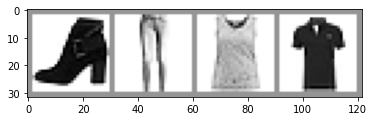

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img/5 + 0.5 # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
dataiter = iter(training_loader)
images, labels = dataiter.next()

# Createa grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print (' '.join(classes[labels[j]] for j in range(4)))

## The Model

The model we'll use in this example is a variant of LeNet-5; it should be familiar from the previous documents.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class GarmentClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = GarmentClassifier()

## Loss Function

For this example, we will be using cross-entropy loss. For demonstration purposes, we'll create batches of dummy output and label values, run them through the loss function, and examine the result.

In [4]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batched of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents teh correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print (dummy_outputs)
print (dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print (f'Total loss for this batch: {loss.item()}')

tensor([[0.2028, 0.3672, 0.1010, 0.6789, 0.1013, 0.0746, 0.6381, 0.2481, 0.8753,
         0.3173],
        [0.5296, 0.1604, 0.2068, 0.4442, 0.2526, 0.3055, 0.8042, 0.2964, 0.6330,
         0.1849],
        [0.4142, 0.5272, 0.3232, 0.8841, 0.3843, 0.2362, 0.9543, 0.8558, 0.9772,
         0.9626],
        [0.3068, 0.7888, 0.6082, 0.5023, 0.7409, 0.0149, 0.6088, 0.0374, 0.4735,
         0.7219]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.405418634414673


## Optimizer
For this example, we'll be using the simple [stochastic gradient descent](https://pytorch.org/docs/stable/optim.html) with momentum.

It can be instructive to try some variations on this optimization scheme:
- Learning rate determines the size of the steps the optimizer takes. What does a different learning rate do to training results, interms of accuracy and convergence time?
- Momentum nudges the optimizer in the direction of strongest gradient over multiple steps. What does changing this value do to the results?
- Try some different optimization algorithms, such as averaged SGD, Adagrad, or Adam. How do the results differ?

In [5]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Training
Below, we have a function that performs one training epoch. It enumerates data from the DataLoader, and on each pass of the loop does the following:
- Gets a batch of training data from the DataLoader
- Zeros the optimizer's gradients
- Performs an inference; make a prediction by passing the inputs through the model
- Calculates the loss of that set of predictions vs the labels on the dataset
- Calculates the backward gradients over the learning weights
- Tells the optimizer to perform one learning step; adjusting the model's weights based on the observed gradients for this batch, according to the optimization algorithm we chose.
- Reports on the loss for every 1000 batches.
- Finally, it reports the average per-batch loss for the last 1000 batches, for comparison with a validation run

In [6]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0
    last_loss = 0
    
    # Here, we use enumerate(training_loader) instear of iter(training_loader)
    # so that we can track the batch index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = model(inputs)
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss/1000 # loss per batch
            print (f' Batch {i + 1} loss: {last_loss}.')
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0
            
    return last_loss


## Per-Epoch Activity
There are a couple of things we'll want to do once per epoch:
- Perform validation by checking our relative loss on a set of data that was not used for training, and report this
- Save a copy of the model

Here, we'll do our reporting in TemsorBoard. This will require going to the command line to start TensorBoard, and opening it in another browser tab.

In [7]:
# Initializing in a seperate cell so we can easily add more epochs to the
# same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/fashion_trainer_{timestamp}')
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000

for epoch in range(EPOCHS):
    print (f'EPOCH {epoch_number + 1}:')
    
    # Make sure gradent tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    model.train(False)
    
    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += loss.item()
        
    avg_vloss = running_vloss / (i+1)
    print (f'LOSS train {avg_loss} valid {avg_vloss}')
    
    # Lof the running loss averaged per batch for both training and validation
    writer.add_scalars('Training vs Validation Loss', 
                      {'Training': avg_loss, 'Validation': avg_vloss},
                      epoch_number + 1)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'model_{timestamp}_{epoch_number}'
        torch.save(model.state_dict(), model_path)
        
    epoch_number += 1

EPOCH 1:
 Batch 1000 loss: 1.7718542886972428.
 Batch 2000 loss: 0.8410577019155026.
 Batch 3000 loss: 0.6695425150608644.
 Batch 4000 loss: 0.6460088050272316.
 Batch 5000 loss: 0.5672090725635645.
 Batch 6000 loss: 0.5424852577676065.
 Batch 7000 loss: 0.5048063411563635.
 Batch 8000 loss: 0.5008821553466841.
 Batch 9000 loss: 0.5145927807218396.
 Batch 10000 loss: 0.48170222150845804.
 Batch 11000 loss: 0.472310052156914.
 Batch 12000 loss: 0.4239868944065529.
 Batch 13000 loss: 0.4331573379948095.
 Batch 14000 loss: 0.4221757805654488.
 Batch 15000 loss: 0.4021545706291654.
LOSS train 0.4021545706291654 valid 2.405418634414673
EPOCH 2:
 Batch 1000 loss: 0.3808577788567782.
 Batch 2000 loss: 0.3843543064353871.
 Batch 3000 loss: 0.3752621689451189.
 Batch 4000 loss: 0.3966358294911915.
 Batch 5000 loss: 0.3540650935532758.
 Batch 6000 loss: 0.3391021918329934.
 Batch 7000 loss: 0.37665931126184293.
 Batch 8000 loss: 0.3628558882194193.
 Batch 9000 loss: 0.35443209272267995.
 Batch 1

To load a saved version of the model:

In [8]:
saved_model = GarmentClassifier()
# Note: PATH not set. Next line throws an error.
saved_model.load_state_dict(torch.load(PATH))

NameError: name 'PATH' is not defined

Once the model is loaded, it's ready for whatever we need it for, be it training, inference or analysis.

Note that if the model has constructor parameters that affect model structure, we'll need to provide them and configure the model identically to the state in which it was saved.

## Other Resources:
- Docs on the [data utilities](https://pytorch.org/docs/stable/data.html), including Dataset and DataLoader, at pytorch.org
- A [note](https://pytorch.org/docs/stable/notes/cuda.html#cuda-memory-pinning) on the use of pinned memory for GPU training
- Documentation onthe datasets available in [TorchVision](https://pytorch.org/vision/stable/datasets.html), [Torch Text](https://pytorch.org/text/stable/datasets.html), and [TorchAudio](https://pytorch.org/audio/stable/datasets.html)
- Documentation on the [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) available in PyTorch
- Documentation on the [torch.optim](https://pytorch.org/docs/stable/optim.html) package, which includes optimizers and related tools, such as learning rate scheduling.
- A [tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html) on saving and loading models.
- The [tutorial](https://pytorch.org/tutorials/) section of pytorch.org contains tutorials on a broad variety of training tasks, including classification in different domains, generative adversarial networks, reinforcement learning, and more.